# Cifar-10 classification

This is a notebook for the [Cifar-10 Kaggle competition](https://www.kaggle.com/competitions/cifar-10/overview). The competition is closed but I use it as a playground to apply deep learning model for computer vision.

## Setup

In [100]:
import cv2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
import time
import visualkeras

In [68]:
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#4469B5", "#D4A418", "#434656", "#B1485A", "#867555"]) 
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Gibson"
plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (6*1.61, 6)

In [69]:
# Display all cell outputs",
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Inputs

Load the inputs and visualise them.

### Training data

In [90]:
# All the images in the train folder are loaded. We make sure that the order of the names is preserved so that labels and images match
def load_images_from_folder(folder):
    images = []
    ids = []
    list_names = os.listdir(folder)
    list_names = [x for _, x in sorted(zip([int(x.replace('.png', '')) for x in list_names], list_names))]
    for filename in list_names:
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
        id = filename.replace('.png', '')
        ids.append(id)                      
    return images, ids

train_data, ids = load_images_from_folder('../data/train/')
train_data = np.array(train_data)

# Data is reshaped to have the expected dimensions
train_data = train_data.reshape(-1, 32, 32, 3)

# The labels are also loaded
train_labels = pd.read_csv('../data/trainLabels.csv')

In [91]:
train_data.shape
train_labels.shape

(50000, 32, 32, 3)

(50000, 2)

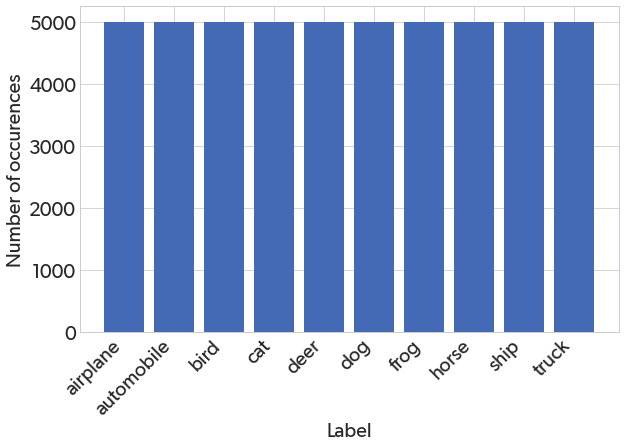

In [92]:
labels, counts = np.unique(train_labels['label'], return_counts=True)
plt.bar(labels, counts, align='center')
plt.xticks(list(range(0, 10)), rotation=45, ha='right')
plt.xlabel('Label')
plt.ylabel('Number of occurences');

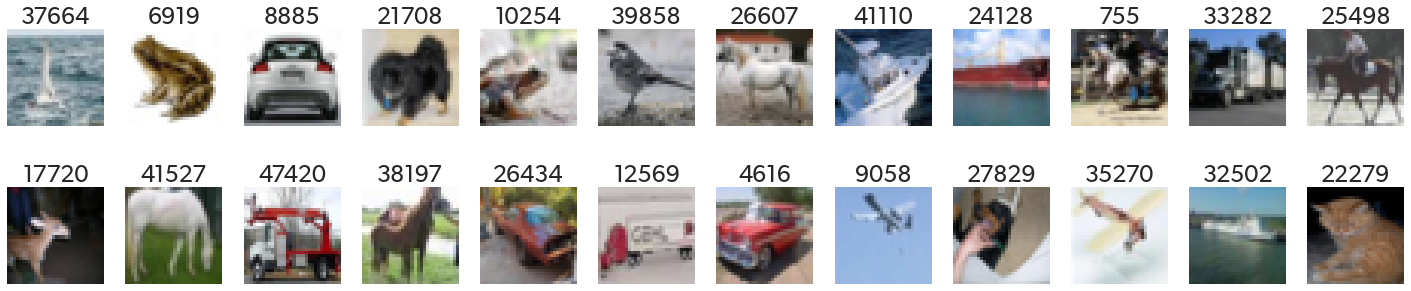

In [93]:
# Glance at the data
nrows = 2
ncols = 12
list_index = np.random.permutation(train_data.shape[0])[:nrows*ncols]
plt.figure(figsize=(20, 5))
for i, j in zip(range(nrows * ncols), list_index):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(train_data[j])
    plt.title(train_labels['label'][j])
    plt.axis("off")
plt.tight_layout()
plt.show();

In [94]:
# Format the target variable as binary class matrices
le = LabelEncoder()
y_train = le.fit_transform(train_labels['label'])
y_train = pd.get_dummies(y_train).values

In [95]:
# Build a validation set
X_train, X_val, y_train, y_val = train_test_split(train_data, y_train, test_size=0.15, random_state=0)

In [101]:
# Define the cnn model architecture
model = Sequential()
model.add(Conv2D(32,  kernel_size = 3,kernel_initializer='he_uniform', activation='relu', input_shape = (32, 32, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size = 3, kernel_initializer='he_uniform', strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, kernel_size = 3, strides=1, kernel_initializer='he_uniform' ,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, kernel_size = 3,kernel_initializer='he_uniform', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((4, 4)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256,kernel_initializer='he_uniform', activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(10, activation = "softmax"))

# Define the optimizer
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)      

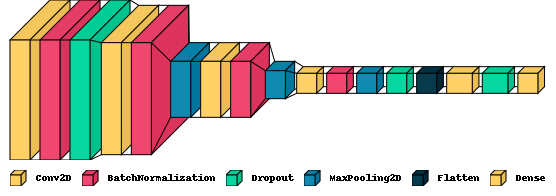

In [103]:
model.summary()
visualkeras.layered_view(model, legend=True)

In [104]:
model_result = model.fit(
    X_train, # Training images
    y_train, # Training labels
    batch_size=32, # Number of images by batch
    epochs=10, # Number of times the entire dataset is used in the training
    validation_data=(X_val, y_val), # Validation data
    verbose=1 # logs during training
)

Epoch 1/10
1329/1329 [==============================] - 194s 145ms/step - loss: 1.6786 - accuracy: 0.3957 - val_loss: 1.3824 - val_accuracy: 0.4885
Epoch 2/10
1329/1329 [==============================] - 231s 174ms/step - loss: 1.2527 - accuracy: 0.5530 - val_loss: 1.1140 - val_accuracy: 0.5964
Epoch 3/10
1329/1329 [==============================] - 202s 152ms/step - loss: 1.0718 - accuracy: 0.6183 - val_loss: 0.9898 - val_accuracy: 0.6492
Epoch 4/10
1329/1329 [==============================] - 216s 162ms/step - loss: 0.9606 - accuracy: 0.6637 - val_loss: 0.8947 - val_accuracy: 0.6889
Epoch 5/10
1329/1329 [==============================] - 274s 206ms/step - loss: 0.8722 - accuracy: 0.6961 - val_loss: 0.8278 - val_accuracy: 0.7123
Epoch 6/10
1329/1329 [==============================] - 223s 168ms/step - loss: 0.8112 - accuracy: 0.7168 - val_loss: 0.8138 - val_accuracy: 0.7147
Epoch 7/10
1329/1329 [==============================] - 222s 167ms/step - loss: 0.7552 - accuracy: 0.7369 - val_

In [105]:
model_result.history['val_accuracy'][-1] * 100
model_result.history['accuracy'][-1] * 100

72.42666482925415

77.68470644950867

In [106]:
test_data, ids = load_images_from_folder('../data/test/')
test_data = np.array(test_data)

# Data is reshaped to have the expected dimensions
test_data = test_data.reshape(-1, 32, 32, 3)

In [121]:
# Make predictions on the test images
predictions = model.predict(test_data)


9375/9375 [==============================] - 302s 32ms/step


In [123]:
pred_labels = le.inverse_transform([np.argmax(pred) for pred in predictions])


In [125]:

# Build the submission file
pd.DataFrame(data={'id': list(range(1, 300001)), 'label': pred_labels}).to_csv('../submission/model0.csv', index=False)

In [124]:
pred_labels[2]

'automobile'